In [1]:
#15.433 - Finance Lab
#William Blair Team

In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In /Users/panqian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/panqian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/panqian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/panqian/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/panqian/anaconda3/lib/python3.7/site-packa

In [3]:
#Reading the provided files
##Reading the Initial File
Col_Names_1 = ['Date', 'Issuer Name', 'Ticker', 'Country Code', 'Country', 'Debt Security Name', 'Bid Price USD', 'Yield', 'Equity Security Name', 'Equity Price USD', 'Equity Total Return', 'Fiscal Date', 'Total Assets', 'Total Liabilities', 'Total Corporate Debt', 'Total Shareholders Equity', 'Shares Outstanding', 'Dividends per Share', 'Dividends Paid', 'Dividend Yield']
Filepath_1 = 'MexicanSecurityData.csv'
Type = {'Date':'object', 'Issuer Name':'object', 'Ticker':'object', 'Country Code':'object', 'Country':'object', 'Debt Security Name':'object', 'Bid Price USD':'float64', 'Yield': 'float64', 'Equity Security Name':'object', 'Equity Price USD':'float64', 'Equity Total Return':'float64', 'Fiscal Date':'float64', 'Total Assets':'float64', 'Total Liabilities':'float64', 'Total Corporate Debt':'float64', 'Total Shareholders Equity':'float64', 'Shares Outstanding':'float64', 'Dividends per Share':'float64', 'Dividends Paid':'float64', 'Dividend Yield':'float64'}
Mexican_Data = pd.read_csv(Filepath_1, header = 0, dtype = Type, names = Col_Names_1, na_values = ' NA')


##Reading the Maturity File
Col_Names_2 = ['Debt Name', 'Maturity']
Filepath_2 = 'MexicanMaturities.xlsx'
Mexican_Maturities = pd.read_excel(Filepath_2, header = 0, names = Col_Names_2, na_values = ' NA')


##Reading the Treasury File
Col_Names_3 = ['Date', '3M Libor', '1Y', '3Y', '5Y', '7Y', '10Y', '15Y', '30Y']
Filepath_3 = 'USTRateData.csv'
Treasury_Rate = pd.read_csv(Filepath_3, header = 0, names = Col_Names_3, na_values = ' NA')


In [4]:
company_list = Mexican_Data.Ticker.unique()
company_list

array(['BANORT', 'CEMEX', 'KOF', 'SCCO', 'TELVIS'], dtype=object)

In [5]:
def info(company, bond):
    
    #First, we get the Total MV of Assets

    ##Getting the necessary inputs with the correct data type
    Total_Debt = pd.to_numeric(company['Total Corporate Debt'], errors = 'coerce').to_numpy()
    Stock_Price = pd.to_numeric(company['Equity Price USD'], errors = 'coerce').to_numpy()
    Shares_Outstanding = pd.to_numeric(company['Shares Outstanding'], errors = 'coerce').to_numpy()

    ##Getting the MV of Equity
    Equity = Stock_Price *  Shares_Outstanding

    ##Getting the MV of Assets
    MV_Assets = Total_Debt + Equity
    
    ##############################
    #Second, we get the Assets' Volatility

    ##We calculate the equity volatility
    Lambda = 0.9075


    Equity_Returns = pd.to_numeric(company['Equity Total Return'], errors = 'coerce').to_numpy()
    l = len(Equity_Returns)
    #Equity_Volatility = np.zeros(l)
    #Equity_Volatility[1] = np.sqrt(Equity_Returns[0]**2)


    ## Using EWMA, assume we are using last 250 trading days (one year)
    EWMA1 = []
    n = len(Equity_Returns)-250
    for i in range(n):
        total = 0
        for j in range(250):
            total = total + (Lambda**(250-j)) * (Equity_Returns[i+j]**2)
        EWMA1.append((total*(1-Lambda))**0.5)


    ##Since we used 250 days as the time window, we cannot calculate the volatilities for the first 250 days. 
    ##For consistency in list lengths of other variables below, I filled EWMA with 250 NaN in the beginning of the list.

    EWMA = [np.nan]*250+EWMA1
    
    ##We get the D/E ratio
    DE_Ratio = Total_Debt / Equity

    ##Finally, we calculate the Asset Volatility
    #####Asset_Volatility = (1 / (1 + DE_Ratio)) * Equity_Volatility
    Asset_Volatility = (1 / (1 + DE_Ratio)) * EWMA

    ##Annuliaze Volatility
    Annual_Volatility = Asset_Volatility*np.sqrt(250)

    
    ##############################
    #Third, we get the strike price - straightforward
    Strike_Price = Total_Debt
    
    ##############################  
    #Fourth, we get the time to maturity

    ##We get the maturity of the Banorte Bond from the Mexican Maturities File
    #bond_pattern = bond[:-17]
    Bond_Maturity = Mexican_Maturities[Mexican_Maturities['Debt Name'].str.contains(bond)]
    Bond_Maturity = pd.to_datetime(Bond_Maturity['Maturity'], format = '%Y%m%d').to_numpy()

    ##We get the date of the bond from the intial file
    Date = pd.to_datetime(company['Date'], format = '%Y/%m/%d').to_numpy()

    #Finally, we take the time difference between the actual date and Maturity to get the time to expiration
    Expiration_Time = ( Bond_Maturity - Date ) / (365 * 24 * 60 * 60 * 10**9)

    
    ##############################  
    #Fifth, we get the risk-free rate for the US Yield Curve
    Treasury_Date = pd.to_datetime(Treasury_Rate['Date'], format = '%Y/%m/%d').to_numpy()
    

    #For a specific trading day of the bond, we get the closest Treasury Date and for this Treasury Date the closest maturity
    Mat = np.array([0.25, 1, 3, 5, 7, 10, 15, 30])
    Risk_Free_Rate = []
    m = len(Date)
    for i in range(m):
        #Specific_Date = Date[i]
        #We get the closest day when treasury rates are reported
        #should be a list of 2555 entries
        day_difference = [abs(Date[i] - x) for x in Treasury_Date]

        #Find the index of that closest bond issuing day 
        #Need to be fixed 
        Day_Index = day_difference.index(min(day_difference))

        #We get the closest maturity for the specific date
        # should be a list of 8 entries
        maturity_difference = [abs(Expiration_Time[i].astype(np.int64) - x) for x in Mat]

        #Find the index of that closest maturity 
        #We made changes here. Added 1 to the index.
        Maturity_Index = maturity_difference.index(min(maturity_difference))+1

        Treasury_Specific_Rate = Treasury_Rate.iloc[Day_Index, Maturity_Index]
        #We get the continuously-compounded rate
        Rate = np.log(1 + Treasury_Specific_Rate)
        Risk_Free_Rate.append(Rate) 
        
    ##############################   
    ## Dividend yield 
    Dividend_yield = pd.to_numeric(company['Dividend Yield'], errors = 'coerce').to_numpy()
    Dividend_yield = Dividend_yield / 100

    Dividend_yield = np.log(1 + Dividend_yield)

    
    return MV_Assets, Annual_Volatility, Strike_Price, Expiration_Time, Risk_Free_Rate, Dividend_yield

In [6]:
def priceBS_div(S0, K, T, r, sigma, q, Type):
    d1 = (np.log(S0/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S0/K) + (r - q - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    if Type == "C":
        return S0*np.exp(-q*T)*stats.norm.cdf(d1,0,1) - K*np.exp(-r*T)*stats.norm.cdf(d2, 0, 1)
    else: 
        return K*np.exp(-r*T)*stats.norm.cdf(-d2, 0, 1) - S0*np.exp(-q*T)*stats.norm.cdf(-d1,0,1)

/Users/panqian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


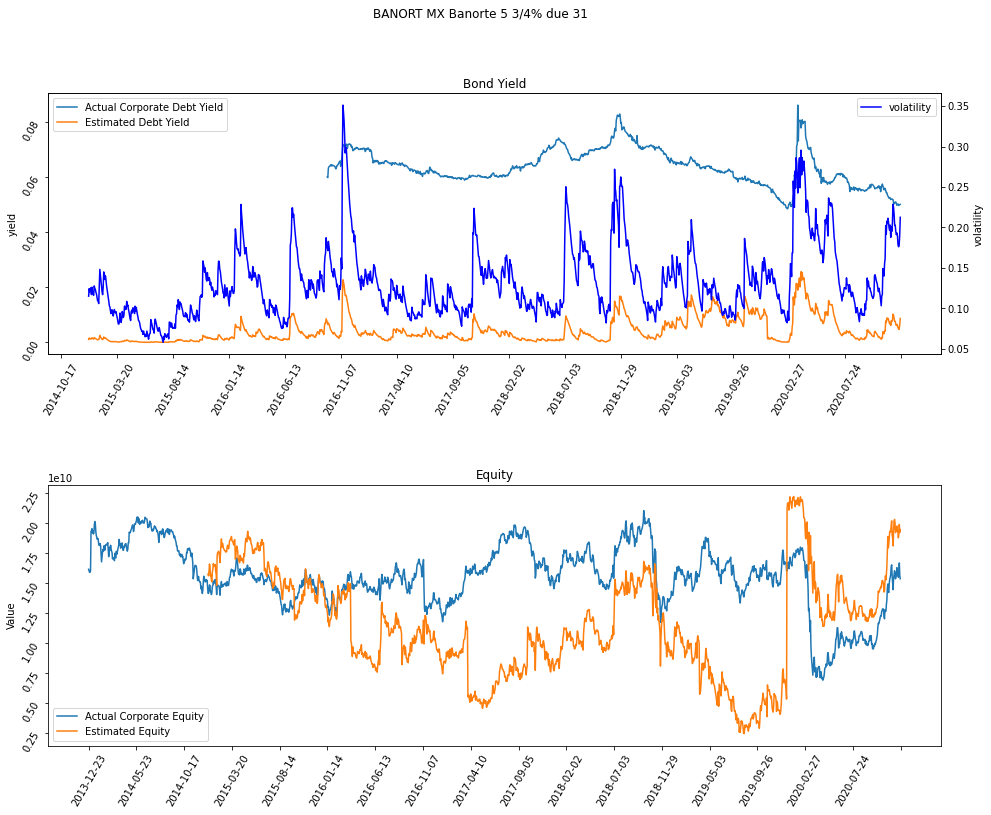

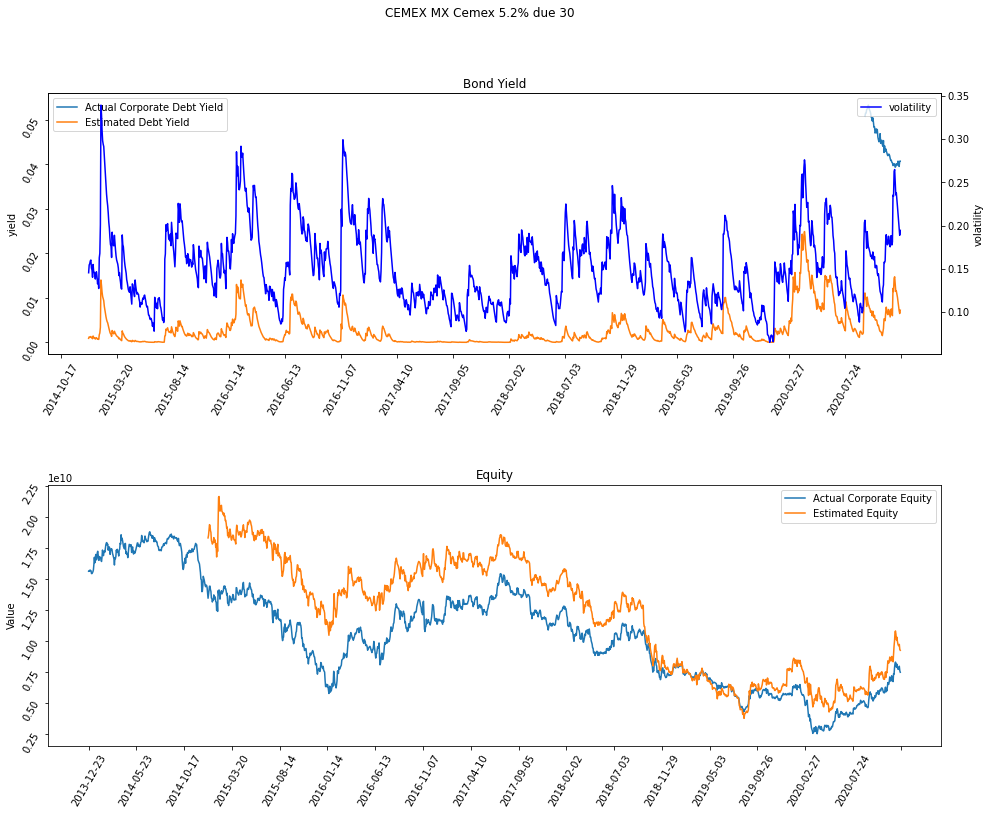

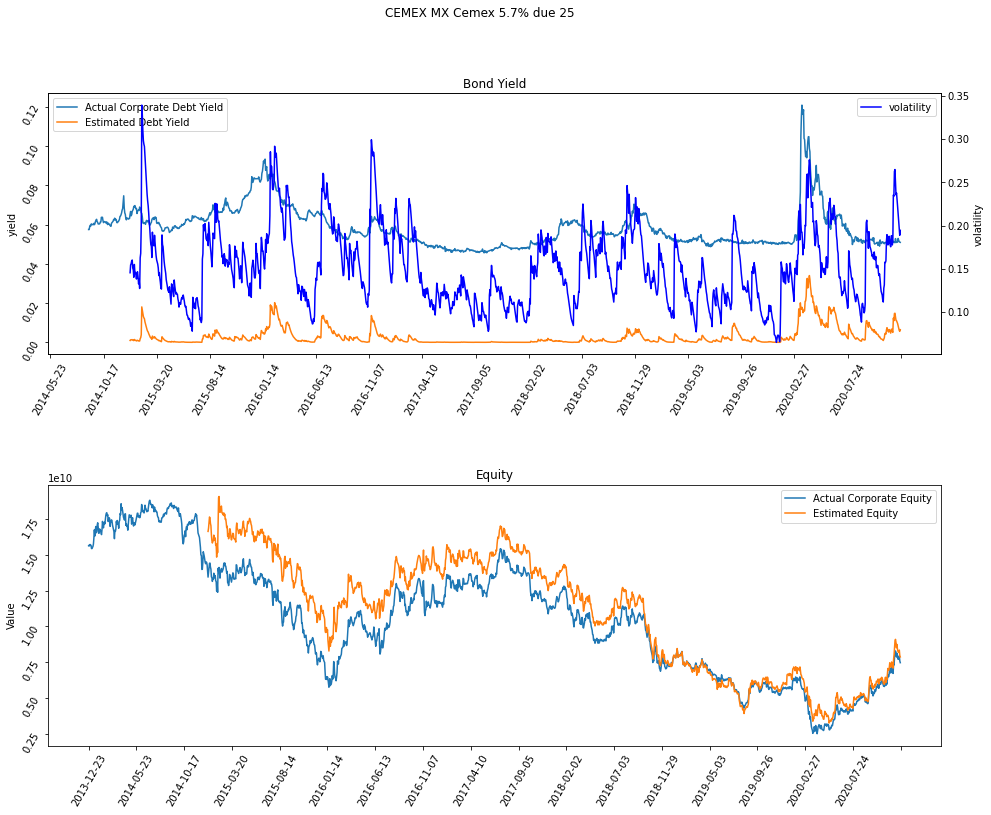

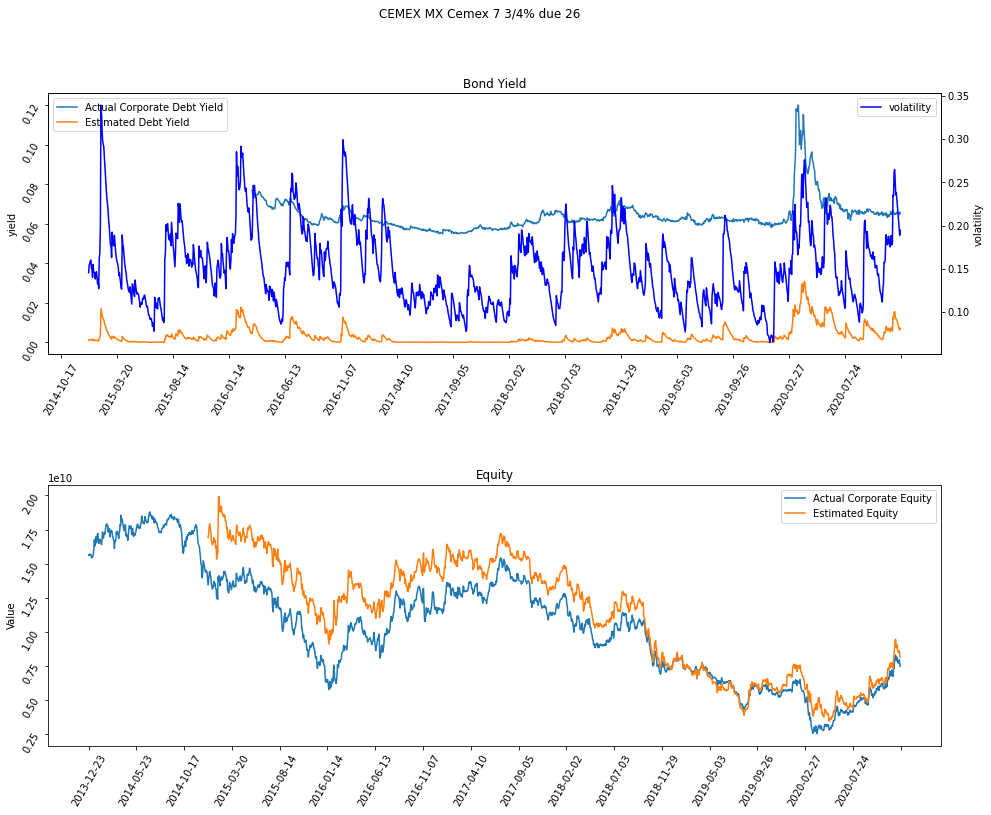

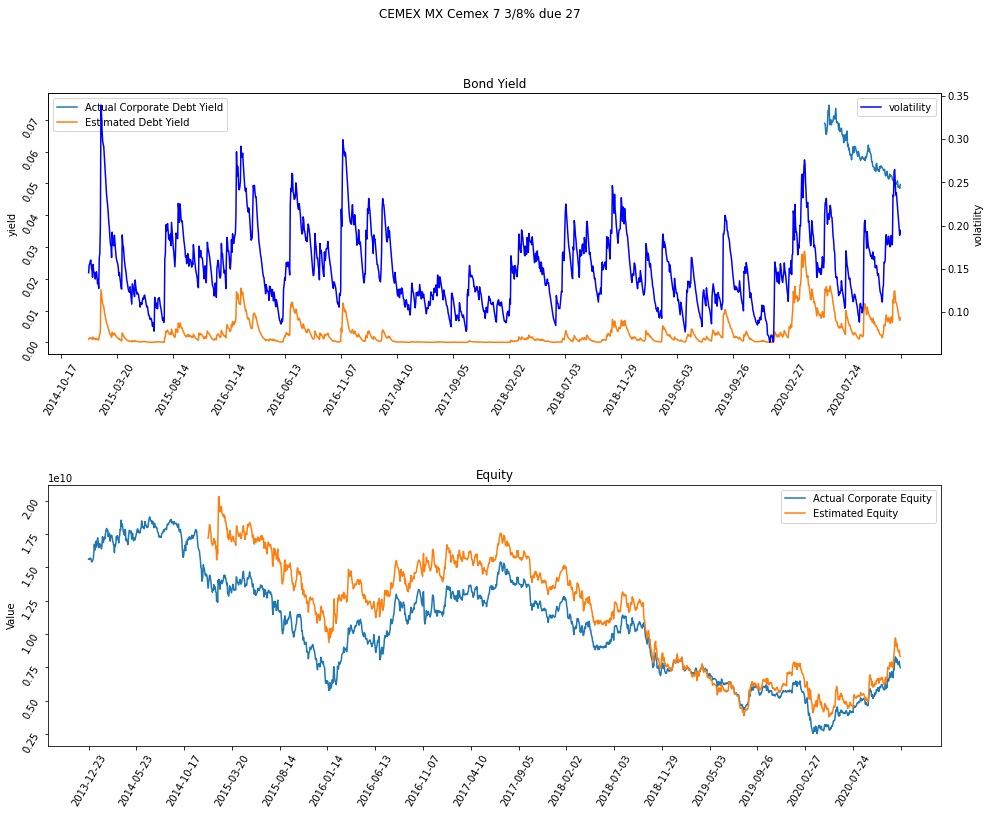

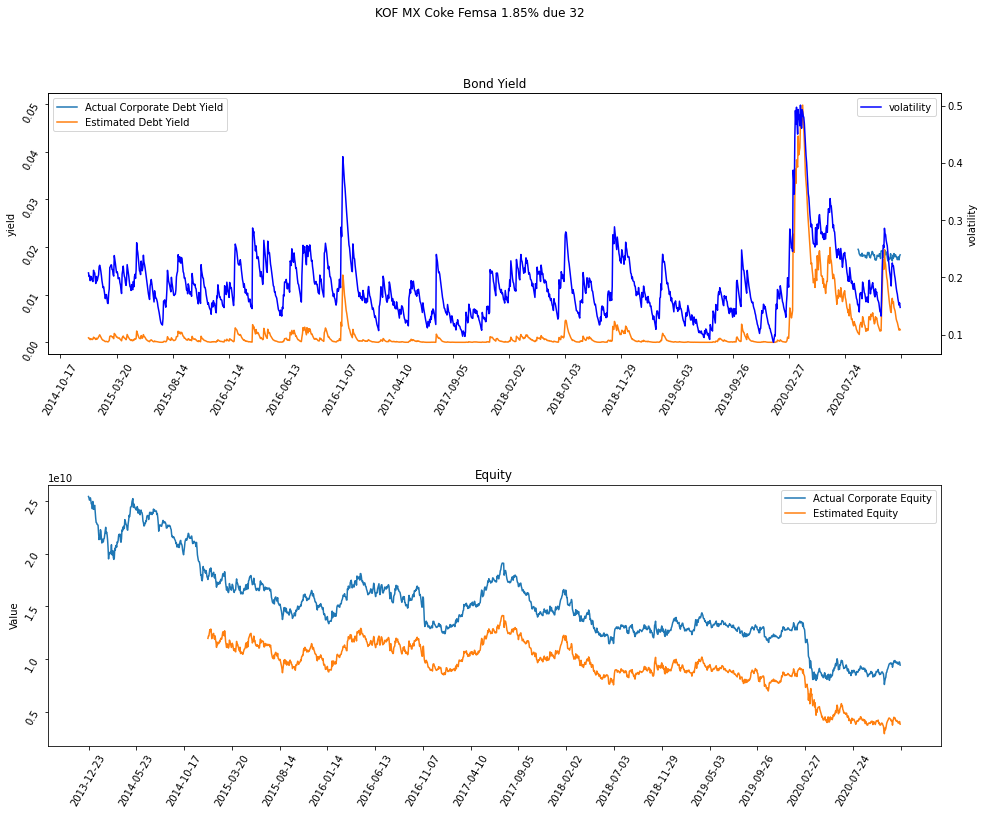

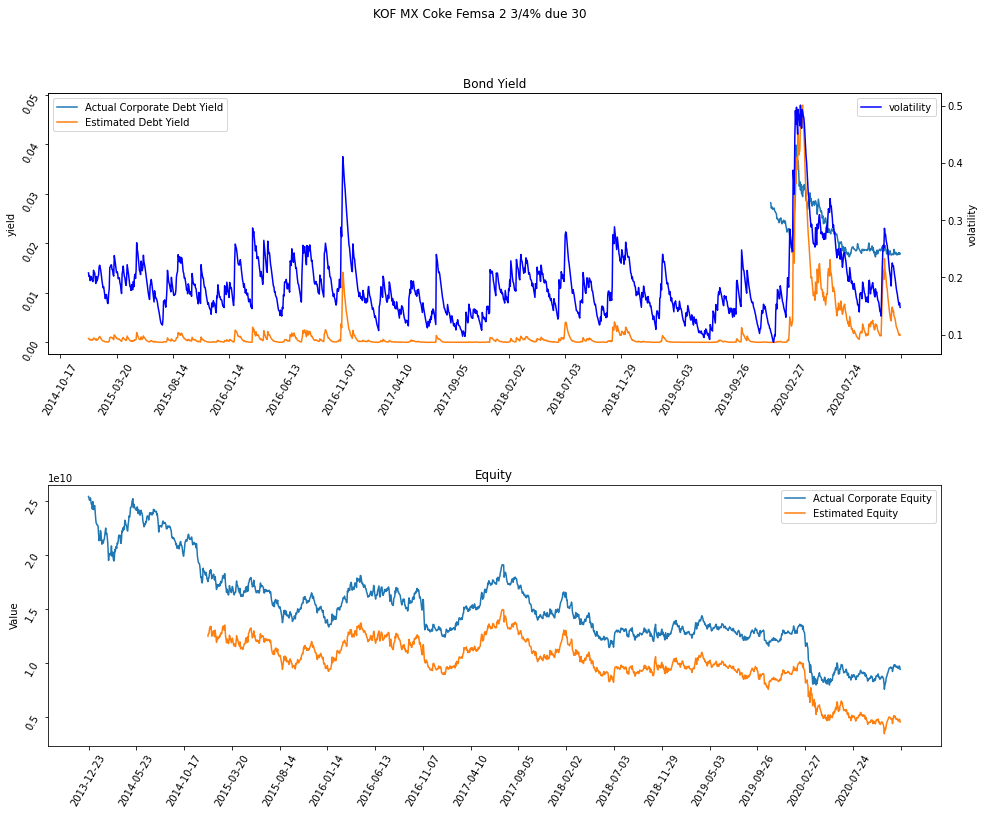

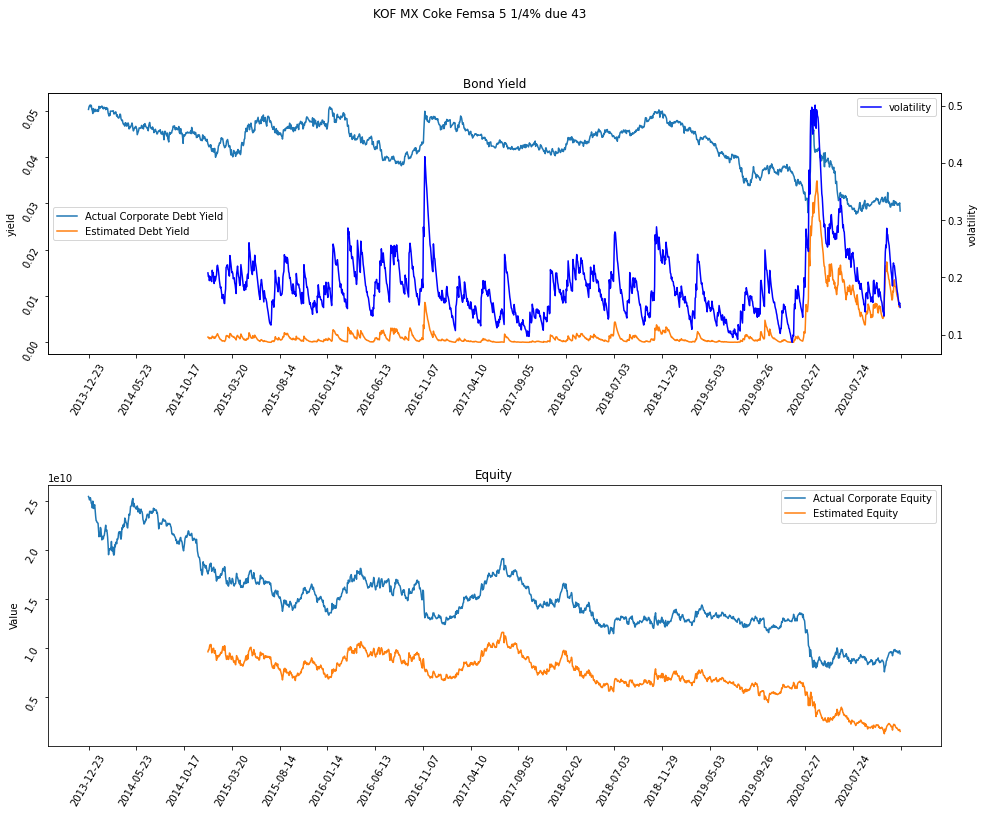

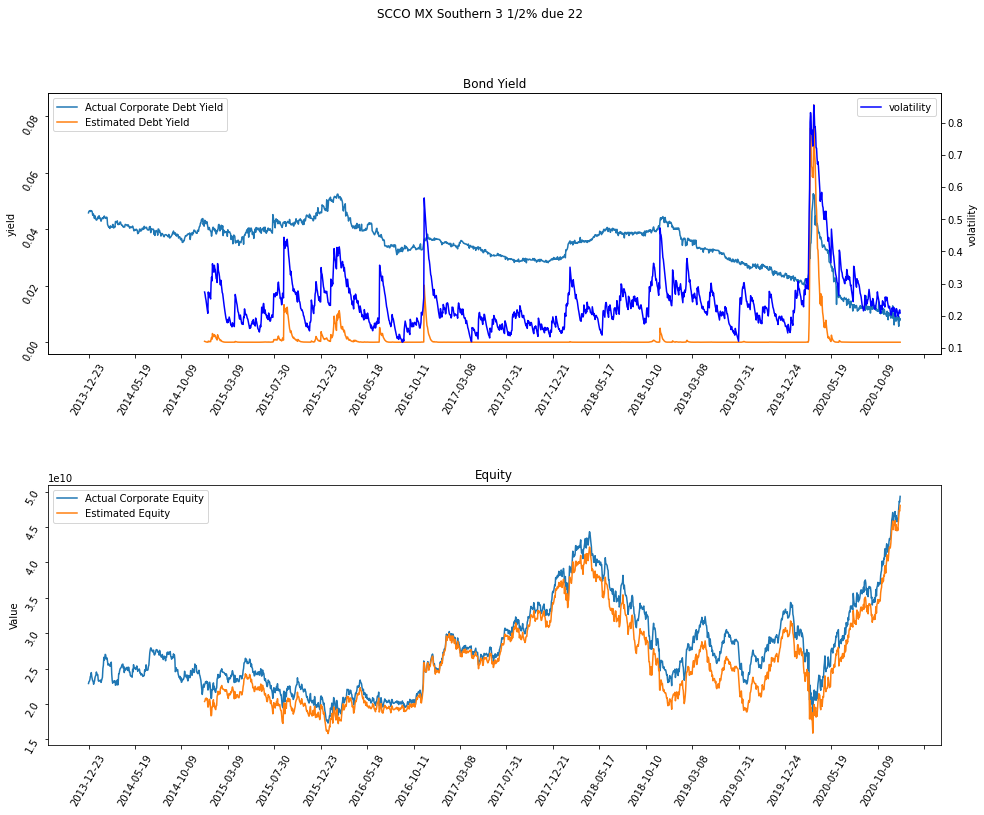

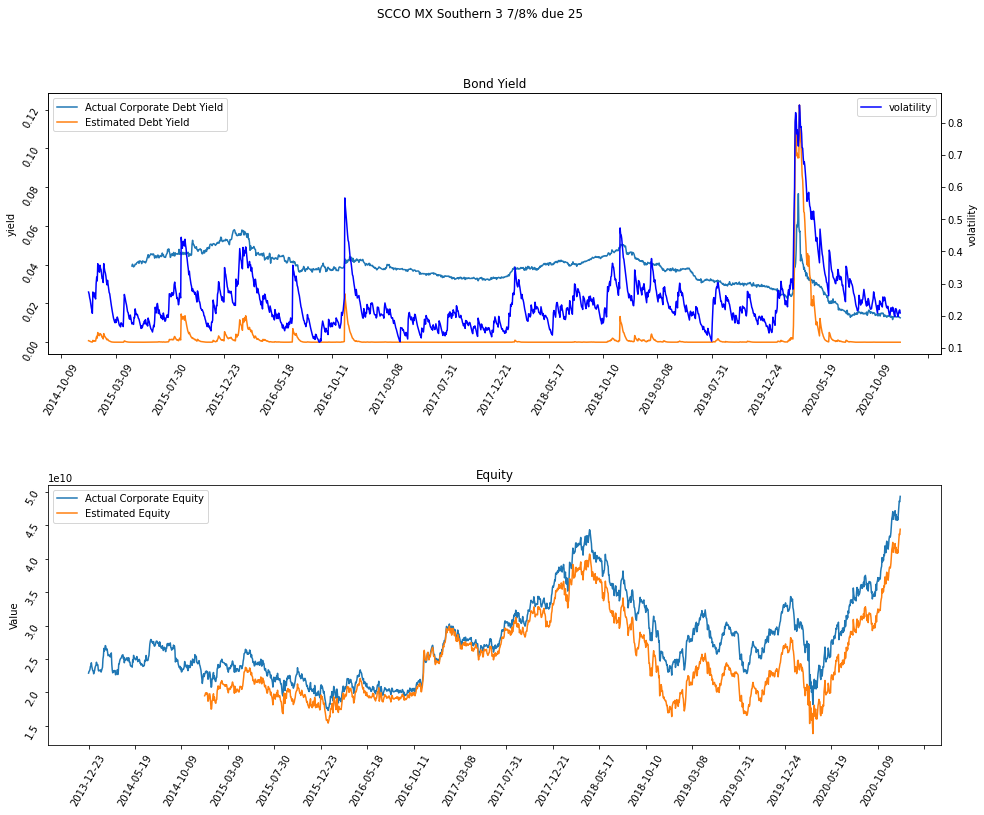

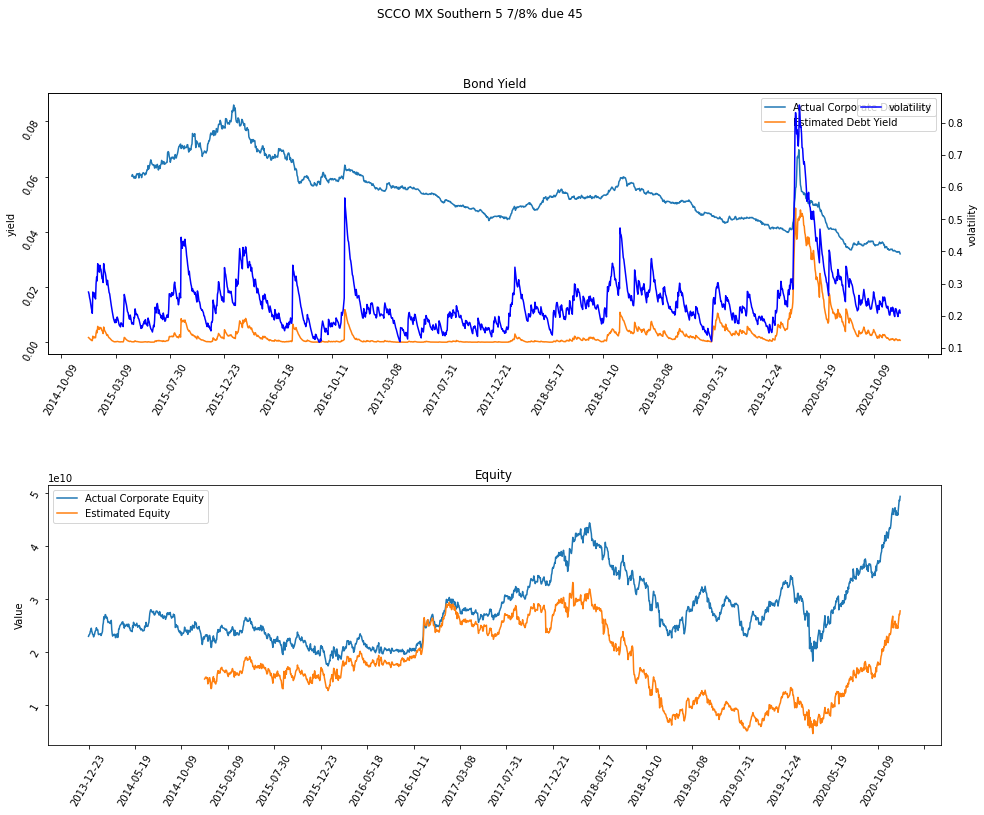

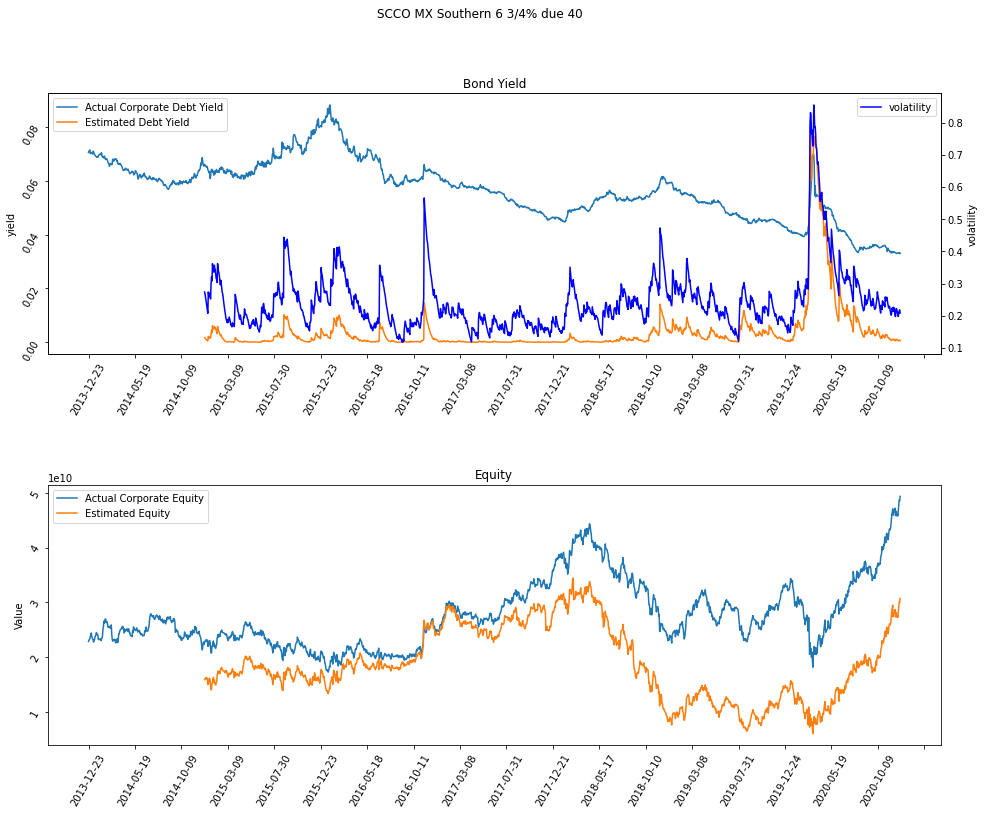

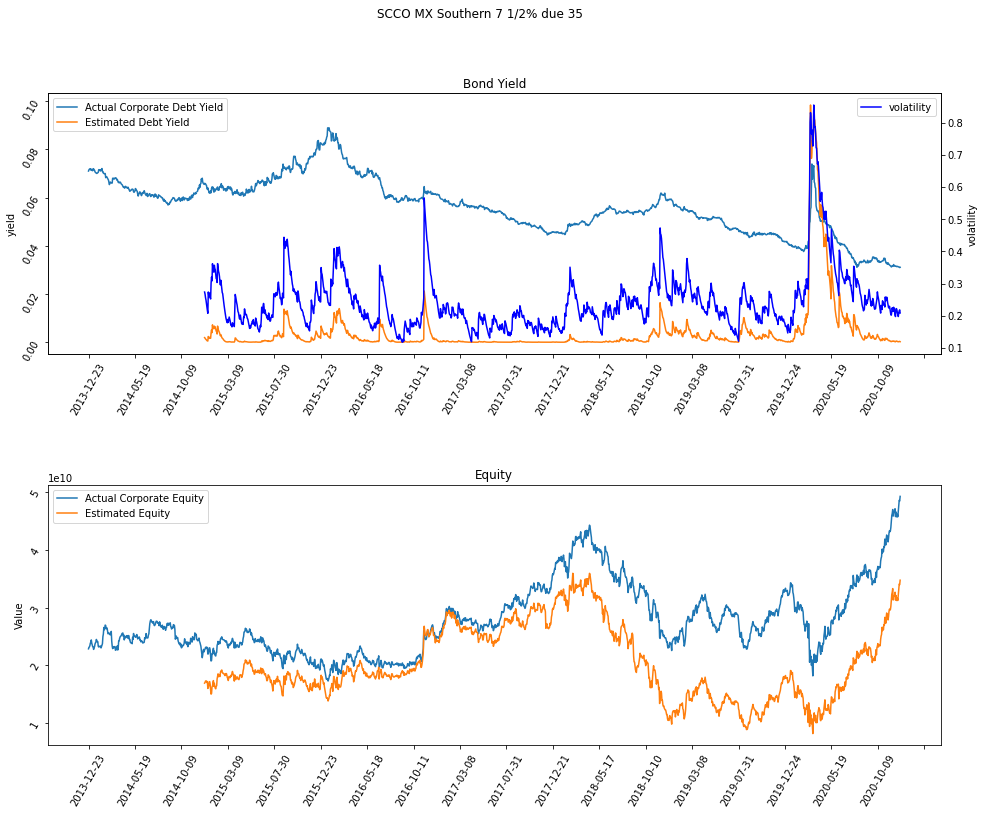

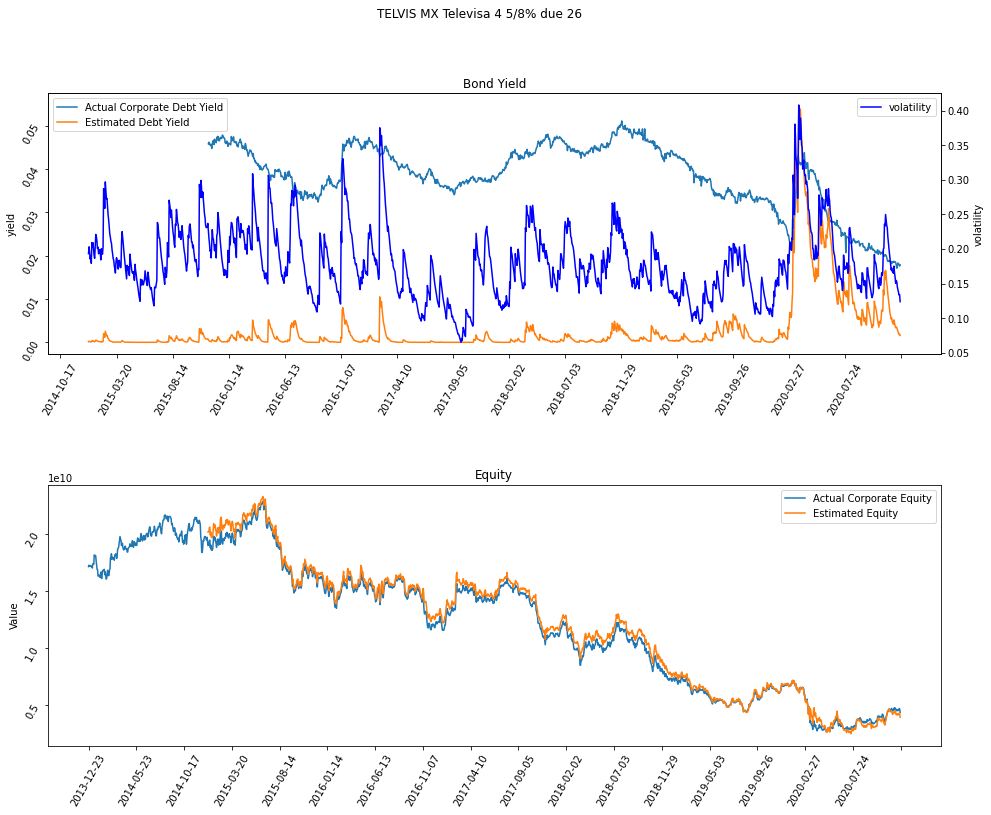

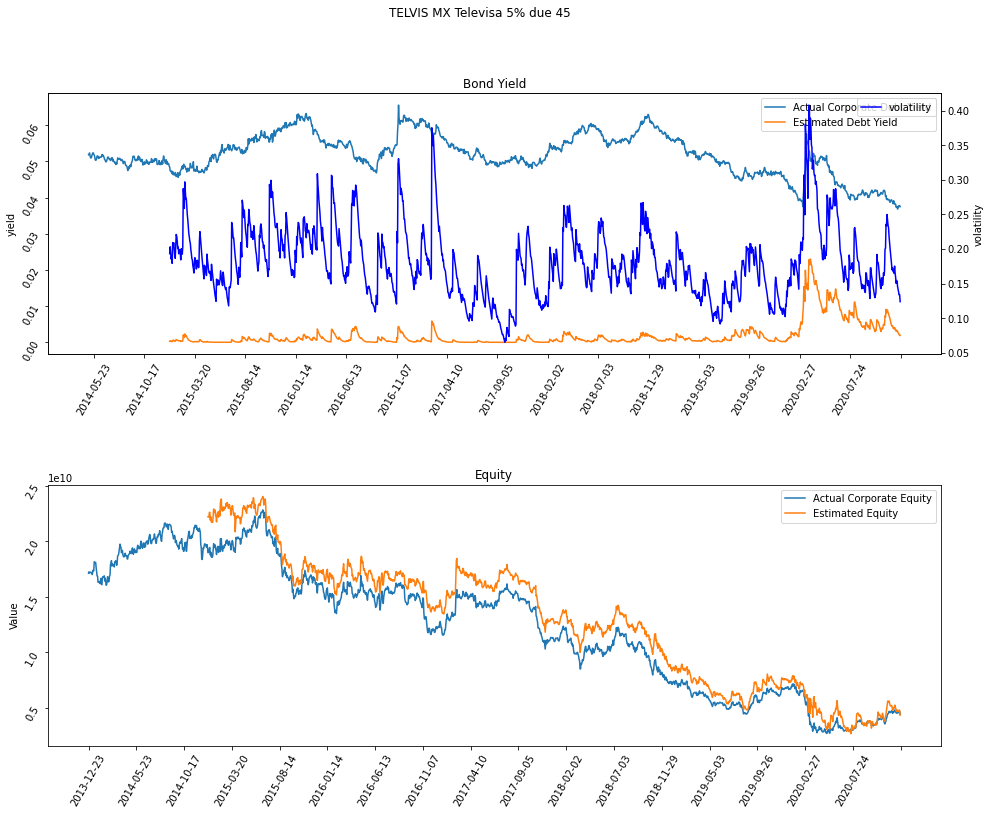

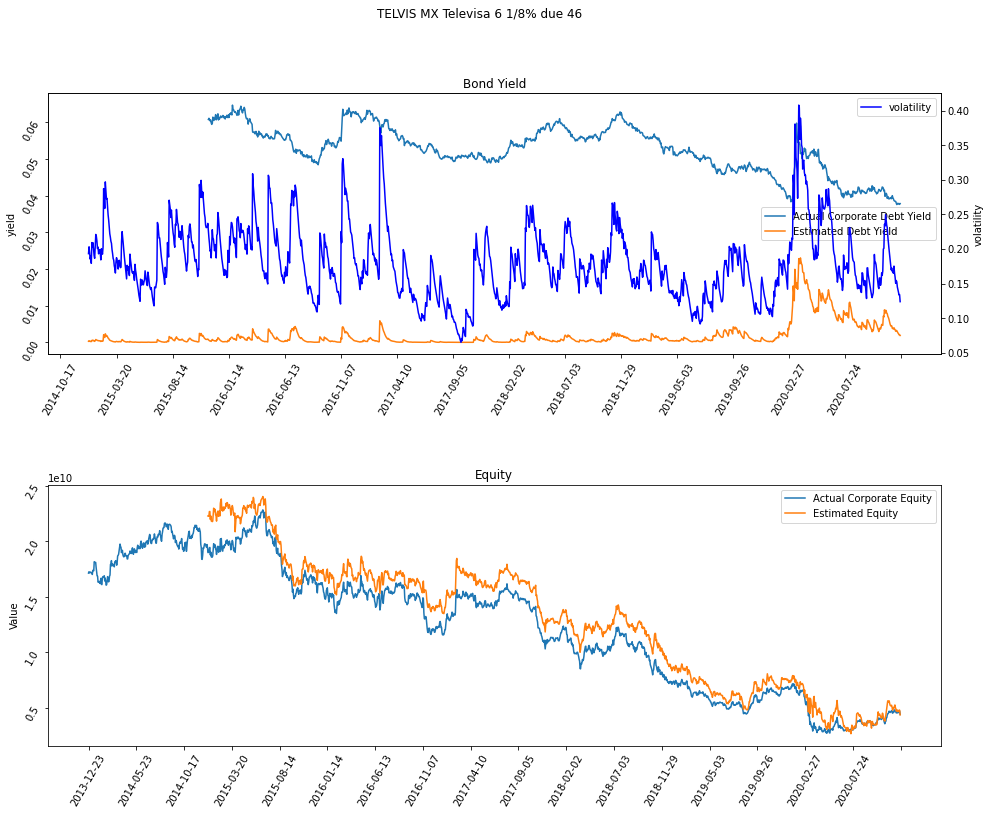

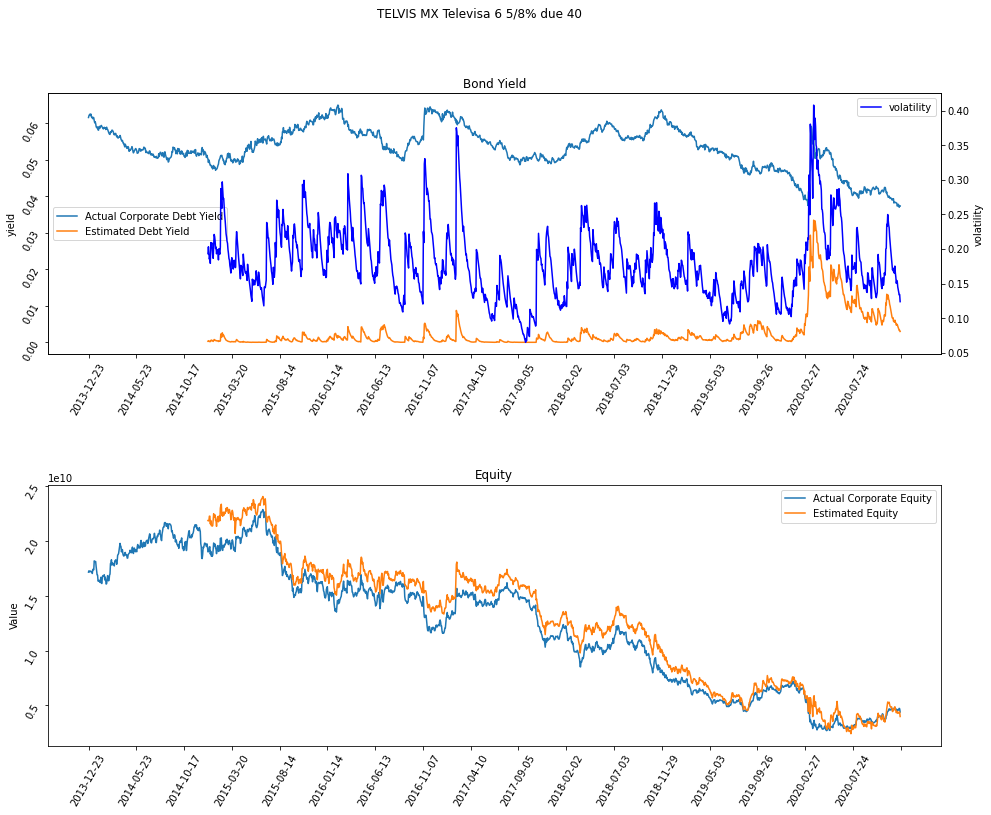

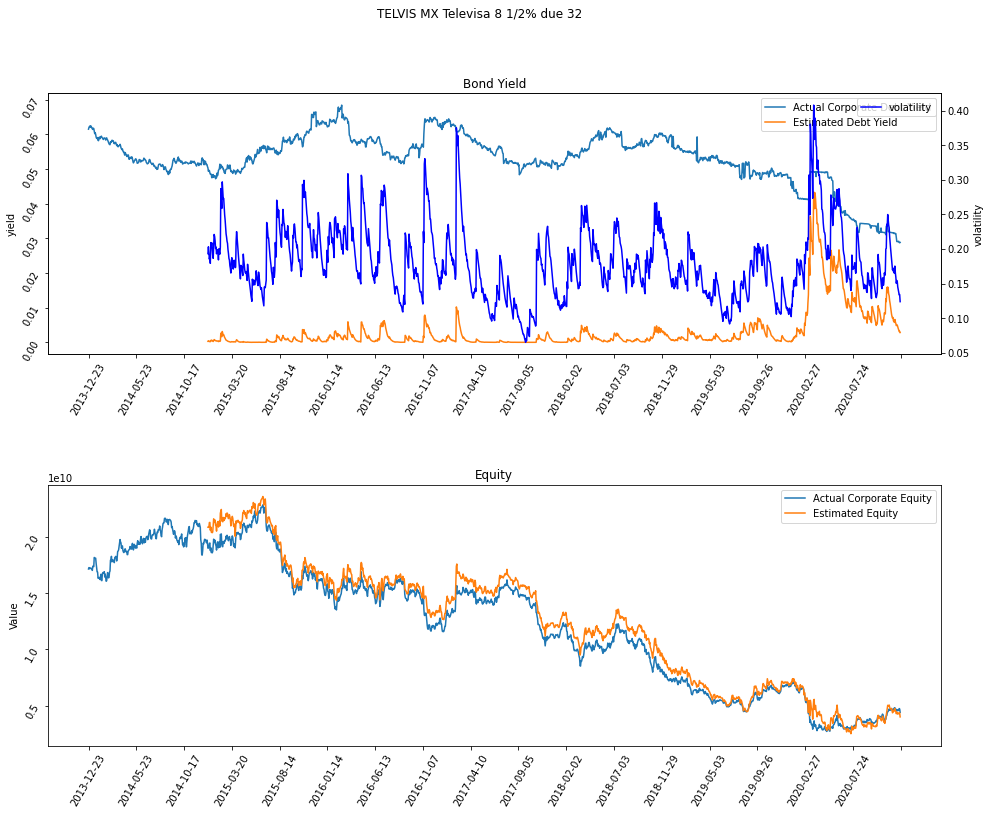

In [8]:
for c in company_list: 
    company = Mexican_Data[Mexican_Data['Ticker'] == c]
    # To speed up, we are thinking dropping all the dates before the bond is issued. EWMA calculation issues. Fix later.
    # company = company.dropna(subset=['Equity Total Return','Bid Price USD']).reset_index(drop=True)
    company = company.dropna(subset=['Equity Total Return'])
 
    bonds_list = company['Debt Security Name'].unique()
    ind = 0
    
    
    for b in bonds_list:
        ind += 1
        
        company_bond = company[company['Debt Security Name'] == b].reset_index(drop=True)
        
        
        # get bond-specific inputs using the previously defined function
        MV_Assets, Annual_Volatility, Strike_Price, Expiration_Time, Risk_Free_Rate, Dividend_yield = info(company_bond, b)
        
        
        simu_liability_price_div = []
        equity_price_div = []
        bond_yield = []
        for i in range(len(Annual_Volatility)):
            # calculate simulated value of bonds using BS model
            simu_liability_price_div.append(Strike_Price[i] - 
                                            priceBS_div(MV_Assets[i], Strike_Price[i], int(Expiration_Time[i]), Risk_Free_Rate[i], 
                                                        Annual_Volatility[i], Dividend_yield[i], 'P'))
            
            # calculate bond yields
            bond_yield.append((company_bond['Total Corporate Debt'][i]/simu_liability_price_div[i])**(1/Expiration_Time[i].astype(np.int64))-1)
            
            
            # calculate equity value using BS model as call option
            # Haven't decide which variable to compare with estimated equity value
            equity_price_div.append(priceBS_div(MV_Assets[i], Strike_Price[i], int(Expiration_Time[i]), Risk_Free_Rate[i], 
                                                        Annual_Volatility[i], Dividend_yield[i], 'C'))
        
        
        # plot the estimated yield against the actual yield
        # plot the estimated equity against actual value
        
        x = company_bond['Date']
        fig, (ax1, ax3) = plt.subplots(nrows = 2, figsize=(16,12))
        # fig.tight_layout()
        fig.subplots_adjust(hspace=0.5)
        plt.suptitle(c + ' ' + b )


        ax1.set_ylabel('yield')
        ax1.plot(x, company_bond['Yield'], label = "Actual Corporate Debt Yield")
        ax1.plot(x, bond_yield, label = "Estimated Debt Yield")
        ax1.set_title('Bond Yield')
        ax1.tick_params(labelrotation=60)
        ax1.legend()
        ax1.xaxis.set_major_locator(ticker.MultipleLocator(100))


        ax2 = ax1.twinx()
        ax2.set_ylabel('volatility')
        ax2.plot(x, Annual_Volatility, label = "volatility",c = 'b')
        ax2.xaxis.set_major_locator(ticker.MultipleLocator(100))
        ax2.legend()


        ax3.plot(x, company_bond['Equity Price USD']*company_bond['Shares Outstanding'], label = "Actual Corporate Equity")
        ax3.plot(x, equity_price_div, label = "Estimated Equity")
        ax3.set_title('Equity')
        ax3.set_ylabel('Value')
        ax3.legend()
        ax3.tick_params(labelrotation=60)
        ax3.xaxis.set_major_locator(ticker.MultipleLocator(100))
        
        plt.savefig('MX ' + c + ' ' + str(ind) + '.png')


In [ ]:
# test
Mexican_Maturities['Debt Name'].unique()[0][:-17]

In [ ]:
# test
a = Mexican_Data[Mexican_Data['Ticker'] == 'BANORT']
a['Debt Security Name'].unique()

In [ ]:
# test
company = Mexican_Data[Mexican_Data['Ticker'] == 'BANORT']
company = company.dropna(subset=['Equity Total Return'])
company_bond = company[company['Debt Security Name'] == 'MX Banorte 5 3/4% due 31'].reset_index(drop=True)

MV_Assets, Annual_Volatility, Strike_Price, Expiration_Time, Risk_Free_Rate, Dividend_yield = info(company_bond, 'MX Banorte 5 3/4% due 31')

In [ ]:
company_bond

In [ ]:
# test
simu_liability_price_div = []
equity_price_div = []
bond_yield = []
for i in range(len(Annual_Volatility)):
    # calculate simulated value of bonds using BS model
    simu_liability_price_div.append(Strike_Price[i] - 
                                    priceBS_div(MV_Assets[i], Strike_Price[i], int(Expiration_Time[i]), Risk_Free_Rate[i], 
                                                Annual_Volatility[i], Dividend_yield[i], 'P'))
    # calculate bond yields
    bond_yield.append((company_bond['Total Corporate Debt'][i]/simu_liability_price_div[i])**(1/Expiration_Time[i].astype(np.int64))-1) 

    # calculate equity value using BS model as call option
    equity_price_div.append(priceBS_div(MV_Assets[i], Strike_Price[i], int(Expiration_Time[i]), Risk_Free_Rate[i], 
                                                Annual_Volatility[i], Dividend_yield[i], 'C'))

In [ ]:
# plotting bond yield and equity

x = company_bond['Date']
fig, (ax1, ax3) = plt.subplots(nrows = 2, figsize=(16,12))
# fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
plt.suptitle('Banorte')


ax1.set_ylabel('yield')
ax1.plot(x, company_bond['Yield'], label = "Actual Corporate Debt Yield")
ax1.plot(x, bond_yield, label = "Estimated Debt Yield")
ax1.set_title('Bond Yield')
ax1.tick_params(labelrotation=60)
ax1.legend()
ax1.xaxis.set_major_locator(ticker.MultipleLocator(100))


ax2 = ax1.twinx()
ax2.set_ylabel('volatility')
ax2.plot(x, Annual_Volatility, label = "volatility",c = 'b')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax2.legend()


ax3.plot(x, company_bond['Equity Price USD']*company_bond['Shares Outstanding'], label = "Actual Corporate Equity")
ax3.plot(x, equity_price_div, label = "Estimated Equity")
ax3.set_title('Equity')
ax3.set_ylabel('Value')
ax3.legend()
ax3.tick_params(labelrotation=60)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(100))


plt.savefig('test' + '.png')